<a href="https://colab.research.google.com/github/KamilLegault/ConcordAI/blob/master/pytorch_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up

In [3]:
!pip install torch

    100% |████████████████████████████████| 519.5MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59ed4000 @  0x7f782fb8a2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [4]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 2 not upgraded.
Need to get 4,154 kB of

In [5]:
!pip install git+https://github.com/szagoruyko/pytorchviz


  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-2ta_li5k
  Running setup.py bdist_wheel for pytorchviz ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-zso23it1/wheels/b9/b9/85/ef34936f58754cb23840fd869be1367b5d525e29915a2a4fe9
Successfully built pytorchviz


## Code

In [0]:
#!/usr/bin/env python
from __future__ import print_function
from itertools import count

import torch
import torch.autograd
import torch.nn.functional as F

In [0]:
POLY_DEGREE = 4
W_target = torch.randn(POLY_DEGREE, 1) * 2
b_target = torch.randn(1) * 2

In [0]:
def poly_desc(W, b):
    """Creates a string description of a polynomial."""
    result = 'y = '
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    result += '{:+.2f}'.format(b[0])
    return result

In [0]:
def make_features(x):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in range(1, POLY_DEGREE+1)], 1)

def f(x):
    """Approximated function."""
    return x.mm(W_target) + b_target.item()

def get_batch(batch_size=32):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(batch_size)
    x = make_features(random)
    y = f(x)
    return x, y

In [0]:
# Define model
fc = torch.nn.Linear(W_target.size(0), 1)

In [16]:
print('==> Learned function:\t' + poly_desc(fc.weight.view(-1), fc.bias))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

==> Learned function:	y = +2.69 x^4 +1.36 x^3 -2.30 x^2 +2.28 x^1 +1.10
==> Actual function:	y = -1.88 x^4 -0.23 x^3 -2.84 x^2 -1.01 x^1 -2.76


In [0]:
for batch_idx in count(1):
    # Get data
    batch_x, batch_y = get_batch()

    # Reset gradients
    fc.zero_grad()

    # Forward pass
    output = F.smooth_l1_loss(fc(batch_x), batch_y)
    loss = output.item()

    # Backward pass
    output.backward()

    # Apply gradients
    for param in fc.parameters():
        param.data.add_(-0.1 * param.grad.data)

    # Stop criterion
    if loss < 1e-3:
        break

In [31]:
print('Loss: {:.6f} after {} batches'.format(loss, batch_idx))
print('==> Learned function:\t' + poly_desc(fc.weight.view(-1), fc.bias))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

Loss: 0.000724 after 1 batches
==> Learned function:	y = -1.88 x^4 -0.23 x^3 -2.84 x^2 -1.02 x^1 -2.72
==> Actual function:	y = -1.88 x^4 -0.23 x^3 -2.84 x^2 -1.01 x^1 -2.76


## Now let's look at the computation graph

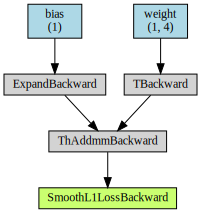

In [52]:
from graphviz import Digraph
import torch
from torch.autograd import Variable

from torchviz import make_dot

batch_x, batch_y = get_batch()
output = F.smooth_l1_loss(fc(batch_x), batch_y)
make_dot(output,params=dict(fc.named_parameters()))